In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Uses engine to fetch the first 10 rows of data
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
connect = session.connection()

# Exploratory Climate Analysis

In [11]:
# Calculate the date 1 year before the last data point in the database
most_recent = engine.execute('SELECT * FROM MEASUREMENT ORDER BY DATE DESC LIMIT 1').fetchall()
last_date = most_recent[0][2]
year = last_date.split('-')[0]
new_year = str(int(year) - 1)
new_date = new_year + '-' + last_date.split('-')[1] + '-' + last_date.split('-')[2]
new_date

'2016-08-23'

In [12]:
# Perform a query to retrieve the data and precipitation scores
last_year_precip = session.query(Measurement.date,Measurement.prcp)\
                    .filter(Measurement.date.between(new_date, last_date)).all()

In [13]:
# Generates the DataFrame with DataFrame() method
precip_df = pd.DataFrame(last_year_precip, columns = ['Date', 'Precipitation'])
precip_df["Date"] = pd.to_datetime(precip_df["Date"])
precip_df = precip_df.sort_values(by=['Date'], ascending=False)
precip_df = precip_df.reset_index(drop=True)
precip_df.head()

,Date,Precipitation
0,2017-08-23,0.45
1,2017-08-23,0.08
2,2017-08-23,0.00
3,2017-08-23,0.00
4,2017-08-22,0.00


<AxesSubplot:xlabel='Date'>

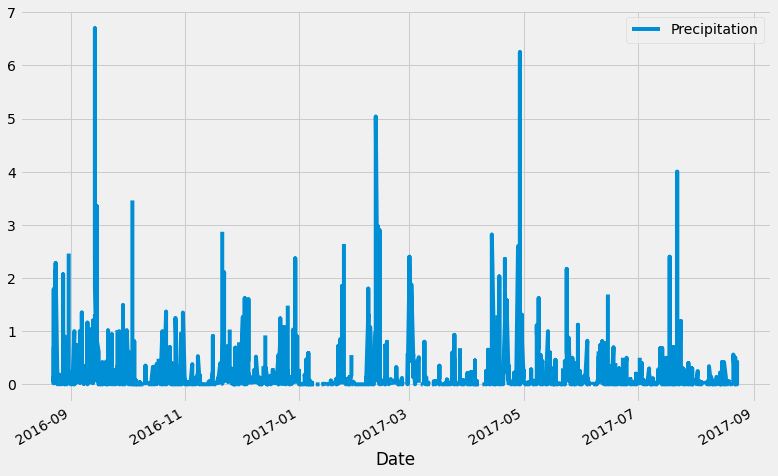

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot('Date', 'Precipitation', figsize = (12,8))

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(func.count(Station.station)).all()
num_stations

[(9)]

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, \
                        func.count(Measurement.station))\
                        .group_by('station')\
                        .order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_station = stations[0][0]
active_station_data = session.query(func.min(Measurement.tobs),\
                        func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                        .filter(Measurement.station == active_station).all()
active_station_data

[(54.0, 85.0, 71.66378066378067)]

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_station_data = session.query(Measurement.date, Measurement.tobs)\
                                .filter(Measurement.date.between(new_date, last_date))\
                                .filter(Measurement.station == active_station)

In [20]:
# This saves the date and tobs query results into a dataframe
temp_station_df = pd.read_sql_query(temp_station_data.statement, connect)
temp_station_df = temp_station_df.rename(columns = {'date':'Date', 'tobs':'Temperature'})
temp_station_df["Date"] = pd.to_datetime(temp_station_df["Date"])
temp_station_df = temp_station_df.sort_values(by=['Date'], ascending=False)
temp_station_df = temp_station_df.reset_index(drop=True)
temp_station_df.head()

,Date,Temperature
0,2017-08-18,79.0
1,2017-08-17,76.0
2,2017-08-16,76.0
3,2017-08-15,77.0
4,2017-08-14,77.0


In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-02-28')[0])

(66.0, 70.375, 73.0)


In [22]:
# Query to collect all dates with recorded temperatures from last year of data and sort them
temp_data = session.query(Measurement.date).filter(Measurement.date.between(new_date, last_date))
temp_df = pd.read_sql_query(temp_data.statement, connect)
temp_df = temp_df.rename(columns = {'date':'Date'})
temp_df = temp_df.drop_duplicates()
temp_df["Date"] = pd.to_datetime(temp_df["Date"])
temp_df = temp_df.sort_values(by=['Date'])
temp_df = temp_df.reset_index(drop = True)
dates = temp_df['Date'].astype(str)

In [23]:
# Runs function for all dates
temp_analysis = [calc_temps(d, d)[0] for d in dates]

ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of ticklabels (366).

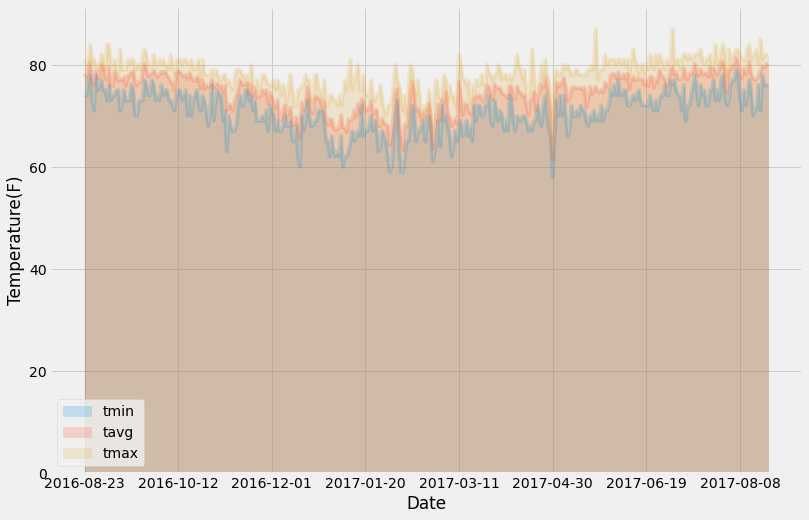

In [24]:
# Building a dataframe and ploting the data
fig, ax = plt.subplots()

temp_analysis_df = pd.DataFrame(temp_analysis, columns = ['tmin','tavg','tmax'],index = dates)
temp_analysis_df.index.name = 'date'
temp_analysis_df.plot(kind = "area",stacked = False,alpha = 0.2, ax=ax, figsize = (12,8))
plt.xlabel("Date")
plt.ylabel("Temperature(F)")
plt.minorticks_off()
ax.xaxis.set_ticklabels(temp_analysis_df.index, rotation = 45)
plt.show()

In [ ]:
temp_analysis_df.index

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_precip_data = session.query(Measurement.date, Measurement.prcp)\
                                .filter(Measurement.date.between(new_date, last_date))\
                                .group_by('station')
station_precip_df = pd.read_sql(station_precip_data.statement, connect, index_col='station')

KeyError: "None of ['station'] are in the columns"